In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import spearmanr, pearsonr
#from lifelines.utils import concordance_index
#from mapie.regression import MapieRegressor
from joblib import parallel_backend
from pathlib import Path
from sklearn.model_selection import train_test_split
import pickle


#parameter_path= Path("/Users/huiyan/Library/CloudStorage/OneDrive-UniversityofHelsinki/PhD project/CK2ab-3rd/Intergrative active/redeal/7th/bioactivity/parameter")
#plot_path= Path("/Users/huiyan/Library/CloudStorage/OneDrive-UniversityofHelsinki/PhD project/CK2ab-3rd/Intergrative active/redeal/7th/bioactivity/plot")
data_path = Path("C:\\Users\\Localadmin_weikaixi\\OneDrive - University of Helsinki\\Private\\ying\\error_model")

# first divide test set to calibration set and test set using fixed SVM parameters

In [2]:
data_path = Path("C:\\Users\\Localadmin_weikaixi\\OneDrive - University of Helsinki\\Private\\ying\\error_model")
df_dataset = pd.read_csv(data_path/"alltrainingset.csv",sep = ",")
df_dataset=df_dataset.drop(["Max Similarity","realsmiles"],axis=1)
df_dataset

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP1016,FP1017,FP1018,FP1019,FP1020,FP1021,FP1022,FP1023,FP1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,-3.732394
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.301030
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,-4.176091
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.711723
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-4.585607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-2.602060
957,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-1.477121
958,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,-4.143015
959,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,-3.778151


In [3]:
df_testset = pd.read_csv(data_path/"testset.csv",sep = ",")

In [4]:
df_testset

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP1016,FP1017,FP1018,FP1019,FP1020,FP1021,FP1022,FP1023,FP1024,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.799341
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,-3.540455
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,-2.596597
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.168413
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.752048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.041393
317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-4.924279
318,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,-4.447158
319,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-2.214844


In [5]:
from sklearn import svm
from scipy.stats import spearmanr

# Separate features and labels
X_train = df_dataset.iloc[:, :1024]  # Use the first 1024 columns as features
y_train = df_dataset.iloc[:, -1]  # Use the last column as the label

X_test = df_testset.iloc[:, :1024]  # Do the same for the test set
y_test = df_testset.iloc[:, -1]


# Spearman

In [11]:
from scipy.stats import wilcoxon

spearman_coefs = [[] for _ in range(8)]  # 8 alpha percentiles
raw_coefs = [[] for _ in range(8)]
kept_ratios = [[] for _ in range(8)]  # 8 alpha percentiles

# Repeat the process 20 times
for i in range(60):
    for j, alpha_percentile in enumerate(range(30, 101, 10)):
        # Divide the test set into a calibration set and a test set
        X_test = df_testset.iloc[:, :1024]  # Do the same for the test set
        y_test = df_testset.iloc[:, -1]
        X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_test, y_test, test_size=0.5)

        # Define and train the first SVM model
        SVM1 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM1.fit(X_train, y_train)

        # Use SVM1 to do prediction in calibrate and test set
        y_calibrate_pred = SVM1.predict(X_calibrate)
        y_test_pred = SVM1.predict(X_test)

        # Define the error
        calibrate_error = abs(y_calibrate - y_calibrate_pred)

        # Set up SVM2 model to predict error value
        SVM2 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM2.fit(X_calibrate, calibrate_error)

        # Define a alpha value as percentile point of true error values in calibrate set
        alpha = np.percentile(calibrate_error, q=alpha_percentile)

        # Use SVM1 and SVM2 to do prediction in test set
        test_error_pred = SVM2.predict(X_test)

        # Only keep the samples whose predicted error value less than alpha
        indices_to_keep = test_error_pred < alpha
        X_test_kept = X_test[indices_to_keep]
        y_test_kept = y_test[indices_to_keep]

        # Calculate kept ratio
        kept_ratio = len(y_test_kept) / len(y_test)
        kept_ratios[j].append(kept_ratio)

        # Skip if no samples are left
        if len(y_test_kept) == 0:
            print(f'Iteration {i+1}, alpha percentile {alpha_percentile}: No samples left after applying error threshold. Skipping...')
            continue

        # Calculate spearman coefficient for the kept samples
        coef, p = spearmanr(y_test_kept, SVM1.predict(X_test_kept))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Spearman coefficient: ', coef)
        spearman_coefs[j].append(coef)

        # Calculate raw spearman coefficient for all samples
        raw_coef, p = spearmanr(y_test, SVM1.predict(X_test))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Raw Spearman coefficient: ', raw_coef)
        raw_coefs[j].append(raw_coef)


Iteration 1 Alpha percentile 30 Spearman coefficient:  0.9636363636363637
Iteration 1 Alpha percentile 30 Raw Spearman coefficient:  0.8639785251843983
Iteration 1 Alpha percentile 40 Spearman coefficient:  0.9090909090909091
Iteration 1 Alpha percentile 40 Raw Spearman coefficient:  0.8247021804925507
Iteration 1 Alpha percentile 50 Spearman coefficient:  0.8482131566301627
Iteration 1 Alpha percentile 50 Raw Spearman coefficient:  0.8112124593407367
Iteration 1 Alpha percentile 60 Spearman coefficient:  0.8785837304430616
Iteration 1 Alpha percentile 60 Raw Spearman coefficient:  0.8355683807135242
Iteration 1 Alpha percentile 70 Spearman coefficient:  0.8273046598132288
Iteration 1 Alpha percentile 70 Raw Spearman coefficient:  0.823213181748466
Iteration 1 Alpha percentile 80 Spearman coefficient:  0.7821351216810402
Iteration 1 Alpha percentile 80 Raw Spearman coefficient:  0.7945668334741254
Iteration 1 Alpha percentile 90 Spearman coefficient:  0.8108426137969114
Iteration 1 Alp

Iteration 7 Alpha percentile 100 Spearman coefficient:  0.8245115597498327
Iteration 7 Alpha percentile 100 Raw Spearman coefficient:  0.8245115597498327
Iteration 8 Alpha percentile 30 Spearman coefficient:  0.8685130592100404
Iteration 8 Alpha percentile 30 Raw Spearman coefficient:  0.8393827529185451
Iteration 8 Alpha percentile 40 Spearman coefficient:  0.9187539893838005
Iteration 8 Alpha percentile 40 Raw Spearman coefficient:  0.8519556668109626
Iteration 8 Alpha percentile 50 Spearman coefficient:  0.9099119077785635
Iteration 8 Alpha percentile 50 Raw Spearman coefficient:  0.8821950385123162
Iteration 8 Alpha percentile 60 Spearman coefficient:  0.8691641287818854
Iteration 8 Alpha percentile 60 Raw Spearman coefficient:  0.8228006989165654
Iteration 8 Alpha percentile 70 Spearman coefficient:  0.8398053672131114
Iteration 8 Alpha percentile 70 Raw Spearman coefficient:  0.8482012108304141
Iteration 8 Alpha percentile 80 Spearman coefficient:  0.8517441189805424
Iteration 8 

Iteration 14 Alpha percentile 80 Spearman coefficient:  0.7923774495795448
Iteration 14 Alpha percentile 80 Raw Spearman coefficient:  0.7714370134561174
Iteration 14 Alpha percentile 90 Spearman coefficient:  0.831213188604955
Iteration 14 Alpha percentile 90 Raw Spearman coefficient:  0.844797343012852
Iteration 14 Alpha percentile 100 Spearman coefficient:  0.8607851919555727
Iteration 14 Alpha percentile 100 Raw Spearman coefficient:  0.8607851919555727
Iteration 15 Alpha percentile 30 Spearman coefficient:  0.7500000000000002
Iteration 15 Alpha percentile 30 Raw Spearman coefficient:  0.8158450748019006
Iteration 15 Alpha percentile 40 Spearman coefficient:  0.9389639391805521
Iteration 15 Alpha percentile 40 Raw Spearman coefficient:  0.8493500780439961
Iteration 15 Alpha percentile 50 Spearman coefficient:  0.8685033135502442
Iteration 15 Alpha percentile 50 Raw Spearman coefficient:  0.8135816199465735
Iteration 15 Alpha percentile 60 Spearman coefficient:  0.8022328445341718
I

Iteration 21 Alpha percentile 60 Spearman coefficient:  0.8333679270702294
Iteration 21 Alpha percentile 60 Raw Spearman coefficient:  0.8200606893578132
Iteration 21 Alpha percentile 70 Spearman coefficient:  0.8301919336003374
Iteration 21 Alpha percentile 70 Raw Spearman coefficient:  0.7868697601723604
Iteration 21 Alpha percentile 80 Spearman coefficient:  0.8405143347081551
Iteration 21 Alpha percentile 80 Raw Spearman coefficient:  0.8294672005524277
Iteration 21 Alpha percentile 90 Spearman coefficient:  0.8279106366384263
Iteration 21 Alpha percentile 90 Raw Spearman coefficient:  0.8209851914793387
Iteration 21 Alpha percentile 100 Spearman coefficient:  0.7952522746129201
Iteration 21 Alpha percentile 100 Raw Spearman coefficient:  0.7952522746129201
Iteration 22 Alpha percentile 30 Spearman coefficient:  0.9411764705882352
Iteration 22 Alpha percentile 30 Raw Spearman coefficient:  0.8564659620031164
Iteration 22 Alpha percentile 40 Spearman coefficient:  0.9526861679484614

Iteration 28 Alpha percentile 40 Spearman coefficient:  0.9159595196744772
Iteration 28 Alpha percentile 40 Raw Spearman coefficient:  0.8754688145056432
Iteration 28 Alpha percentile 50 Spearman coefficient:  0.8734814649755444
Iteration 28 Alpha percentile 50 Raw Spearman coefficient:  0.8389582306610744
Iteration 28 Alpha percentile 60 Spearman coefficient:  0.8192390434506944
Iteration 28 Alpha percentile 60 Raw Spearman coefficient:  0.8357104961886737
Iteration 28 Alpha percentile 70 Spearman coefficient:  0.8707206601485145
Iteration 28 Alpha percentile 70 Raw Spearman coefficient:  0.8505229604418846
Iteration 28 Alpha percentile 80 Spearman coefficient:  0.8235400275157665
Iteration 28 Alpha percentile 80 Raw Spearman coefficient:  0.8297640152562833
Iteration 28 Alpha percentile 90 Spearman coefficient:  0.8758461559793229
Iteration 28 Alpha percentile 90 Raw Spearman coefficient:  0.8625387581915678
Iteration 28 Alpha percentile 100 Spearman coefficient:  0.7918302210168241


Iteration 34 Alpha percentile 100 Spearman coefficient:  0.8022295757121392
Iteration 34 Alpha percentile 100 Raw Spearman coefficient:  0.8022295757121392
Iteration 35 Alpha percentile 30 Spearman coefficient:  0.8821428571428571
Iteration 35 Alpha percentile 30 Raw Spearman coefficient:  0.8576664218686595
Iteration 35 Alpha percentile 40 Spearman coefficient:  0.9402560455192034
Iteration 35 Alpha percentile 40 Raw Spearman coefficient:  0.8366149898689936
Iteration 35 Alpha percentile 50 Spearman coefficient:  0.7756097560975611
Iteration 35 Alpha percentile 50 Raw Spearman coefficient:  0.8520619581196655
Iteration 35 Alpha percentile 60 Spearman coefficient:  0.8545591982067708
Iteration 35 Alpha percentile 60 Raw Spearman coefficient:  0.8071205097860583
Iteration 35 Alpha percentile 70 Spearman coefficient:  0.7889904710603034
Iteration 35 Alpha percentile 70 Raw Spearman coefficient:  0.7986509199785011
Iteration 35 Alpha percentile 80 Spearman coefficient:  0.8581253155992635

Iteration 41 Alpha percentile 80 Spearman coefficient:  0.7884776627576575
Iteration 41 Alpha percentile 80 Raw Spearman coefficient:  0.7871909546394353
Iteration 41 Alpha percentile 90 Spearman coefficient:  0.8237860168189798
Iteration 41 Alpha percentile 90 Raw Spearman coefficient:  0.8210722768833298
Iteration 41 Alpha percentile 100 Spearman coefficient:  0.8464788996712221
Iteration 41 Alpha percentile 100 Raw Spearman coefficient:  0.8464788996712221
Iteration 42 Alpha percentile 30 Spearman coefficient:  0.6666666666666667
Iteration 42 Alpha percentile 30 Raw Spearman coefficient:  0.8214446953011979
Iteration 42 Alpha percentile 40 Spearman coefficient:  0.7454961832061069
Iteration 42 Alpha percentile 40 Raw Spearman coefficient:  0.8363453110401887
Iteration 42 Alpha percentile 50 Spearman coefficient:  0.8212007504690433
Iteration 42 Alpha percentile 50 Raw Spearman coefficient:  0.8474521197297344
Iteration 42 Alpha percentile 60 Spearman coefficient:  0.8089800882044872

Iteration 48 Alpha percentile 60 Spearman coefficient:  0.8301268989001105
Iteration 48 Alpha percentile 60 Raw Spearman coefficient:  0.7907583632475492
Iteration 48 Alpha percentile 70 Spearman coefficient:  0.8519410738780125
Iteration 48 Alpha percentile 70 Raw Spearman coefficient:  0.837329675633449
Iteration 48 Alpha percentile 80 Spearman coefficient:  0.8387551467457404
Iteration 48 Alpha percentile 80 Raw Spearman coefficient:  0.8377902546757229
Iteration 48 Alpha percentile 90 Spearman coefficient:  0.8170469573309529
Iteration 48 Alpha percentile 90 Raw Spearman coefficient:  0.8278099086862631
Iteration 48 Alpha percentile 100 Spearman coefficient:  0.8338581250838824
Iteration 48 Alpha percentile 100 Raw Spearman coefficient:  0.8338581250838824
Iteration 49 Alpha percentile 30 Spearman coefficient:  0.9240929684291712
Iteration 49 Alpha percentile 30 Raw Spearman coefficient:  0.8487363787488463
Iteration 49 Alpha percentile 40 Spearman coefficient:  0.9127919911012237


Iteration 55 Alpha percentile 40 Spearman coefficient:  0.9230270054857798
Iteration 55 Alpha percentile 40 Raw Spearman coefficient:  0.8071830184973207
Iteration 55 Alpha percentile 50 Spearman coefficient:  0.841374924464796
Iteration 55 Alpha percentile 50 Raw Spearman coefficient:  0.829296382190161
Iteration 55 Alpha percentile 60 Spearman coefficient:  0.819363747664391
Iteration 55 Alpha percentile 60 Raw Spearman coefficient:  0.8184866979588774
Iteration 55 Alpha percentile 70 Spearman coefficient:  0.8873759891920939
Iteration 55 Alpha percentile 70 Raw Spearman coefficient:  0.8807725543248431
Iteration 55 Alpha percentile 80 Spearman coefficient:  0.805482865590459
Iteration 55 Alpha percentile 80 Raw Spearman coefficient:  0.817953600946914
Iteration 55 Alpha percentile 90 Spearman coefficient:  0.8783307621493842
Iteration 55 Alpha percentile 90 Raw Spearman coefficient:  0.8727840002877835
Iteration 55 Alpha percentile 100 Spearman coefficient:  0.844336353747008
Iterat

In [12]:
# Create a bar plot
labels = [ "0.7","0.6",'0.5','0.4', '0.3', '0.2', '0.1', '0.0']  # Alpha percentiles
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

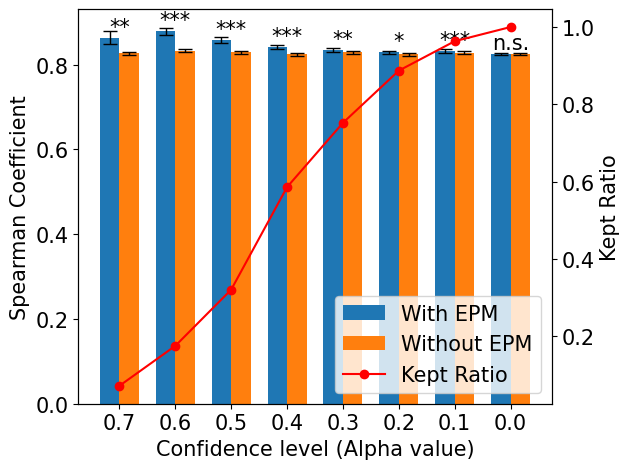

In [13]:
# Calculate the SEM for the coefficients
sem_spearman = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in spearman_coefs]
sem_raw = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in raw_coefs]

fig, ax = plt.subplots()
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars
rects1 = ax.bar(x - width/2, [np.mean(coefs) for coefs in spearman_coefs], width, yerr=sem_spearman, 
                label='With EPM', capsize=5)
rects2 = ax.bar(x + width/2, [np.mean(coefs) for coefs in raw_coefs], width, yerr=sem_raw, 
                label='Without EPM', capsize=5)

def get_significance_asterisks(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'  # not significant

# Calculate p-values and store asterisks
p_values = []
for i in range(7):  # Calculate for the first 7 bars
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    p_values.append(get_significance_asterisks(p))
p_values.append(get_significance_asterisks(1))  # Add the last p-value of 1

# Adjust error bar width
for bar in [rects1, rects2]:
    for err_line in bar.errorbar.lines[2]:
        err_line.set_linewidth(1)

# Plot line
ax2.plot(x, [np.mean(ratios) for ratios in kept_ratios], color='red', marker='o', label='Kept Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Spearman Coefficient', fontsize=15)
ax2.set_ylabel('Kept Ratio', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Confidence level (Alpha value)', fontsize=15)

# Add asterisk notation above the middle of each group of bars
for idx, (r1, r2) in enumerate(zip(rects1, rects2)):
    middle_x = r1.get_x() + (r2.get_x() + r2.get_width() - r1.get_x()) / 2
    max_height = max(r1.get_height(), r2.get_height())
    ax.text(middle_x, max_height + 0.002, p_values[idx], ha='center', va='bottom', fontsize=15)

# Set fontsize of tick labels on both x and y axes to 15
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)  # Assuming ax2 is for the secondary y-axis

# Adjust location of the legend to avoid overlap
fig.legend(loc="upper right", bbox_to_anchor=(1,0.3), bbox_transform=ax.transAxes, fontsize=15)

fig.tight_layout()






plt.savefig('errormodel_spearman.pdf', format='pdf') 

In [30]:
# Wilcoxon test
for i in range(7):
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    print('Alpha percentile:', labels[i])
    print('Wilcoxon test: W = %0.5f, p-value = %0.5f' % (w, p))


Alpha percentile: 0.7
Wilcoxon test: W = 580.00000, p-value = 0.01366
Alpha percentile: 0.6
Wilcoxon test: W = 415.00000, p-value = 0.00023
Alpha percentile: 0.5
Wilcoxon test: W = 600.00000, p-value = 0.02040
Alpha percentile: 0.4
Wilcoxon test: W = 457.00000, p-value = 0.00075
Alpha percentile: 0.3
Wilcoxon test: W = 532.00000, p-value = 0.00481
Alpha percentile: 0.2
Wilcoxon test: W = 468.00000, p-value = 0.00100
Alpha percentile: 0.1
Wilcoxon test: W = 538.00000, p-value = 0.02189


# Pearson

In [6]:
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
spearman_coefs = [[] for _ in range(8)]  # 8 alpha percentiles
raw_coefs = [[] for _ in range(8)]
kept_ratios = [[] for _ in range(8)]  # 8 alpha percentiles

# Repeat the process 20 times
for i in range(60):
    for j, alpha_percentile in enumerate(range(30, 101, 10)):
        # Divide the test set into a calibration set and a test set
        X_test = df_testset.iloc[:, :1024]  # Do the same for the test set
        y_test = df_testset.iloc[:, -1]
        X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_test, y_test, test_size=0.5)

        # Define and train the first SVM model
        SVM1 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM1.fit(X_train, y_train)

        # Use SVM1 to do prediction in calibrate and test set
        y_calibrate_pred = SVM1.predict(X_calibrate)
        y_test_pred = SVM1.predict(X_test)

        # Define the error
        calibrate_error = abs(y_calibrate - y_calibrate_pred)

        # Set up SVM2 model to predict error value
        SVM2 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM2.fit(X_calibrate, calibrate_error)

        # Define a alpha value as percentile point of true error values in calibrate set
        alpha = np.percentile(calibrate_error, q=alpha_percentile)

        # Use SVM1 and SVM2 to do prediction in test set
        test_error_pred = SVM2.predict(X_test)

        # Only keep the samples whose predicted error value less than alpha
        indices_to_keep = test_error_pred < alpha
        X_test_kept = X_test[indices_to_keep]
        y_test_kept = y_test[indices_to_keep]

        # Calculate kept ratio
        kept_ratio = len(y_test_kept) / len(y_test)
        kept_ratios[j].append(kept_ratio)

        # Skip if no samples are left
        if len(y_test_kept) == 0:
            print(f'Iteration {i+1}, alpha percentile {alpha_percentile}: No samples left after applying error threshold. Skipping...')
            continue

        # Calculate spearman coefficient for the kept samples
        coef, p = pearsonr(y_test_kept, SVM1.predict(X_test_kept))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Pearson coefficient: ', coef)
        spearman_coefs[j].append(coef)

        # Calculate raw spearman coefficient for all samples
        raw_coef, p = pearsonr(y_test, SVM1.predict(X_test))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Raw Pearson coefficient: ', raw_coef)
        raw_coefs[j].append(raw_coef)


Iteration 1 Alpha percentile 30 Pearson coefficient:  0.9781843631236147
Iteration 1 Alpha percentile 30 Raw Pearson coefficient:  0.8997440827013575
Iteration 1 Alpha percentile 40 Pearson coefficient:  0.9435565122872118
Iteration 1 Alpha percentile 40 Raw Pearson coefficient:  0.863053593812707
Iteration 1 Alpha percentile 50 Pearson coefficient:  0.9446686644276364
Iteration 1 Alpha percentile 50 Raw Pearson coefficient:  0.9115357092430391
Iteration 1 Alpha percentile 60 Pearson coefficient:  0.9074683552162695
Iteration 1 Alpha percentile 60 Raw Pearson coefficient:  0.8827179137984911
Iteration 1 Alpha percentile 70 Pearson coefficient:  0.9077616782857871
Iteration 1 Alpha percentile 70 Raw Pearson coefficient:  0.9009731321460588
Iteration 1 Alpha percentile 80 Pearson coefficient:  0.8537304410143743
Iteration 1 Alpha percentile 80 Raw Pearson coefficient:  0.850919225981494
Iteration 1 Alpha percentile 90 Pearson coefficient:  0.8795696940542674
Iteration 1 Alpha percentile 

Iteration 7 Alpha percentile 100 Pearson coefficient:  0.8711172146305779
Iteration 7 Alpha percentile 100 Raw Pearson coefficient:  0.8711172146305779
Iteration 8 Alpha percentile 30 Pearson coefficient:  0.811914321364133
Iteration 8 Alpha percentile 30 Raw Pearson coefficient:  0.8734498726297946
Iteration 8 Alpha percentile 40 Pearson coefficient:  0.9087563298254168
Iteration 8 Alpha percentile 40 Raw Pearson coefficient:  0.904687708113089
Iteration 8 Alpha percentile 50 Pearson coefficient:  0.7339964241549013
Iteration 8 Alpha percentile 50 Raw Pearson coefficient:  0.8583087358708561
Iteration 8 Alpha percentile 60 Pearson coefficient:  0.8784288584734253
Iteration 8 Alpha percentile 60 Raw Pearson coefficient:  0.8633418936624868
Iteration 8 Alpha percentile 70 Pearson coefficient:  0.8934898293859123
Iteration 8 Alpha percentile 70 Raw Pearson coefficient:  0.872339246985955
Iteration 8 Alpha percentile 80 Pearson coefficient:  0.8913590577106847
Iteration 8 Alpha percentile

Iteration 14 Alpha percentile 90 Pearson coefficient:  0.8535821075981496
Iteration 14 Alpha percentile 90 Raw Pearson coefficient:  0.853178167584696
Iteration 14 Alpha percentile 100 Pearson coefficient:  0.9009204535384258
Iteration 14 Alpha percentile 100 Raw Pearson coefficient:  0.9009204535384258
Iteration 15 Alpha percentile 30 Pearson coefficient:  0.672232155692673
Iteration 15 Alpha percentile 30 Raw Pearson coefficient:  0.8825853341522943
Iteration 15 Alpha percentile 40 Pearson coefficient:  0.9244743620902308
Iteration 15 Alpha percentile 40 Raw Pearson coefficient:  0.8773665763660747
Iteration 15 Alpha percentile 50 Pearson coefficient:  0.933423554012101
Iteration 15 Alpha percentile 50 Raw Pearson coefficient:  0.8828109178227318
Iteration 15 Alpha percentile 60 Pearson coefficient:  0.8630130736978701
Iteration 15 Alpha percentile 60 Raw Pearson coefficient:  0.866689273786147
Iteration 15 Alpha percentile 70 Pearson coefficient:  0.8973809549446846
Iteration 15 Alp

Iteration 21 Alpha percentile 70 Pearson coefficient:  0.8481244909913536
Iteration 21 Alpha percentile 70 Raw Pearson coefficient:  0.868081418592938
Iteration 21 Alpha percentile 80 Pearson coefficient:  0.8858756300445118
Iteration 21 Alpha percentile 80 Raw Pearson coefficient:  0.8822804726945107
Iteration 21 Alpha percentile 90 Pearson coefficient:  0.8806576048150309
Iteration 21 Alpha percentile 90 Raw Pearson coefficient:  0.8801161163668577
Iteration 21 Alpha percentile 100 Pearson coefficient:  0.9005217225405334
Iteration 21 Alpha percentile 100 Raw Pearson coefficient:  0.9005217225405334
Iteration 22 Alpha percentile 30 Pearson coefficient:  0.9473015450682893
Iteration 22 Alpha percentile 30 Raw Pearson coefficient:  0.883568030340481
Iteration 22 Alpha percentile 40 Pearson coefficient:  0.8609329419946389
Iteration 22 Alpha percentile 40 Raw Pearson coefficient:  0.8891545476742372
Iteration 22 Alpha percentile 50 Pearson coefficient:  0.9387769726413149
Iteration 22 A

Iteration 28 Alpha percentile 50 Pearson coefficient:  0.8801485864917457
Iteration 28 Alpha percentile 50 Raw Pearson coefficient:  0.8610062243524818
Iteration 28 Alpha percentile 60 Pearson coefficient:  0.8626511338939835
Iteration 28 Alpha percentile 60 Raw Pearson coefficient:  0.8576929161517627
Iteration 28 Alpha percentile 70 Pearson coefficient:  0.8842206032813472
Iteration 28 Alpha percentile 70 Raw Pearson coefficient:  0.888852062701304
Iteration 28 Alpha percentile 80 Pearson coefficient:  0.8722637622271969
Iteration 28 Alpha percentile 80 Raw Pearson coefficient:  0.8810981234957657
Iteration 28 Alpha percentile 90 Pearson coefficient:  0.8846938422526628
Iteration 28 Alpha percentile 90 Raw Pearson coefficient:  0.8831917886789136
Iteration 28 Alpha percentile 100 Pearson coefficient:  0.8694865501820138
Iteration 28 Alpha percentile 100 Raw Pearson coefficient:  0.8694865501820138
Iteration 29 Alpha percentile 30 Pearson coefficient:  0.9879095521440672
Iteration 29 

Iteration 35 Alpha percentile 30 Pearson coefficient:  0.9368255465211892
Iteration 35 Alpha percentile 30 Raw Pearson coefficient:  0.8907490027959535
Iteration 35 Alpha percentile 40 Pearson coefficient:  0.8645134655848846
Iteration 35 Alpha percentile 40 Raw Pearson coefficient:  0.8350265023239715
Iteration 35 Alpha percentile 50 Pearson coefficient:  0.9371786489785235
Iteration 35 Alpha percentile 50 Raw Pearson coefficient:  0.8536705094425706
Iteration 35 Alpha percentile 60 Pearson coefficient:  0.89540590623468
Iteration 35 Alpha percentile 60 Raw Pearson coefficient:  0.8715967514828719
Iteration 35 Alpha percentile 70 Pearson coefficient:  0.8720671209691145
Iteration 35 Alpha percentile 70 Raw Pearson coefficient:  0.8531163510704964
Iteration 35 Alpha percentile 80 Pearson coefficient:  0.9043186098554536
Iteration 35 Alpha percentile 80 Raw Pearson coefficient:  0.89100418459596
Iteration 35 Alpha percentile 90 Pearson coefficient:  0.8799492220231745
Iteration 35 Alpha

Iteration 41 Alpha percentile 100 Pearson coefficient:  0.8755532796366431
Iteration 41 Alpha percentile 100 Raw Pearson coefficient:  0.8755532796366431
Iteration 42 Alpha percentile 30 Pearson coefficient:  0.9647030998426209
Iteration 42 Alpha percentile 30 Raw Pearson coefficient:  0.8932199364533916
Iteration 42 Alpha percentile 40 Pearson coefficient:  0.9484589340113319
Iteration 42 Alpha percentile 40 Raw Pearson coefficient:  0.8762107992744388
Iteration 42 Alpha percentile 50 Pearson coefficient:  0.8753623049479824
Iteration 42 Alpha percentile 50 Raw Pearson coefficient:  0.8788711643889846
Iteration 42 Alpha percentile 60 Pearson coefficient:  0.7877144408184167
Iteration 42 Alpha percentile 60 Raw Pearson coefficient:  0.8794464310810997
Iteration 42 Alpha percentile 70 Pearson coefficient:  0.8793646243168138
Iteration 42 Alpha percentile 70 Raw Pearson coefficient:  0.8791343784902153
Iteration 42 Alpha percentile 80 Pearson coefficient:  0.9091084080286377
Iteration 42

Iteration 48 Alpha percentile 80 Pearson coefficient:  0.9024162629728598
Iteration 48 Alpha percentile 80 Raw Pearson coefficient:  0.9042032736246509
Iteration 48 Alpha percentile 90 Pearson coefficient:  0.8672842386332199
Iteration 48 Alpha percentile 90 Raw Pearson coefficient:  0.8663140375262416
Iteration 48 Alpha percentile 100 Pearson coefficient:  0.9155956239536024
Iteration 48 Alpha percentile 100 Raw Pearson coefficient:  0.9155956239536024
Iteration 49 Alpha percentile 30 Pearson coefficient:  0.9333856270088275
Iteration 49 Alpha percentile 30 Raw Pearson coefficient:  0.8930575423178967
Iteration 49 Alpha percentile 40 Pearson coefficient:  0.938163054071766
Iteration 49 Alpha percentile 40 Raw Pearson coefficient:  0.8913140232951027
Iteration 49 Alpha percentile 50 Pearson coefficient:  0.9074720397226614
Iteration 49 Alpha percentile 50 Raw Pearson coefficient:  0.8736797762106734
Iteration 49 Alpha percentile 60 Pearson coefficient:  0.8698435647616158
Iteration 49 

Iteration 55 Alpha percentile 60 Pearson coefficient:  0.8865614599415167
Iteration 55 Alpha percentile 60 Raw Pearson coefficient:  0.8894357565459072
Iteration 55 Alpha percentile 70 Pearson coefficient:  0.8989276405536606
Iteration 55 Alpha percentile 70 Raw Pearson coefficient:  0.8658589561221666
Iteration 55 Alpha percentile 80 Pearson coefficient:  0.846821278770377
Iteration 55 Alpha percentile 80 Raw Pearson coefficient:  0.8306055059521398
Iteration 55 Alpha percentile 90 Pearson coefficient:  0.8798352957467505
Iteration 55 Alpha percentile 90 Raw Pearson coefficient:  0.8734123129147843
Iteration 55 Alpha percentile 100 Pearson coefficient:  0.8837555013213177
Iteration 55 Alpha percentile 100 Raw Pearson coefficient:  0.8837555013213177
Iteration 56 Alpha percentile 30 Pearson coefficient:  0.9503358169515148
Iteration 56 Alpha percentile 30 Raw Pearson coefficient:  0.8614329760369739
Iteration 56 Alpha percentile 40 Pearson coefficient:  0.9184759598110572
Iteration 56 

In [7]:
# Create a bar plot
labels = [ "0.7","0.6",'0.5','0.4', '0.3', '0.2', '0.1', '0.0']  # Alpha percentiles
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

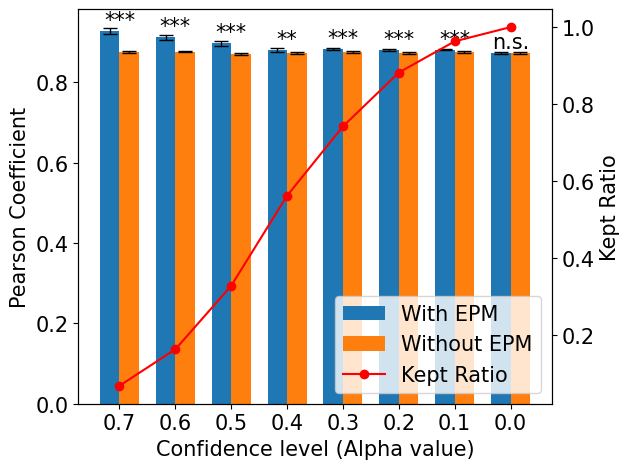

In [8]:
# Calculate the SEM for the coefficients
sem_spearman = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in spearman_coefs]
sem_raw = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in raw_coefs]

fig, ax = plt.subplots()
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars
rects1 = ax.bar(x - width/2, [np.mean(coefs) for coefs in spearman_coefs], width, yerr=sem_spearman, 
                label='With EPM', capsize=5)
rects2 = ax.bar(x + width/2, [np.mean(coefs) for coefs in raw_coefs], width, yerr=sem_raw, 
                label='Without EPM', capsize=5)

def get_significance_asterisks(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'  # not significant

# Calculate p-values and store asterisks
p_values = []
for i in range(7):  # Calculate for the first 7 bars
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    p_values.append(get_significance_asterisks(p))
p_values.append(get_significance_asterisks(1))  # Add the last p-value of 1

# Adjust error bar width
for bar in [rects1, rects2]:
    for err_line in bar.errorbar.lines[2]:
        err_line.set_linewidth(1)

# Plot line
ax2.plot(x, [np.mean(ratios) for ratios in kept_ratios], color='red', marker='o', label='Kept Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Coefficient', fontsize=15)
ax2.set_ylabel('Kept Ratio', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Confidence level (Alpha value)', fontsize=15)

# Add asterisk notation above the middle of each group of bars
for idx, (r1, r2) in enumerate(zip(rects1, rects2)):
    middle_x = r1.get_x() + (r2.get_x() + r2.get_width() - r1.get_x()) / 2
    max_height = max(r1.get_height(), r2.get_height())
    ax.text(middle_x, max_height + 0.002, p_values[idx], ha='center', va='bottom', fontsize=15)

# Set fontsize of tick labels on both x and y axes to 15
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)  # Assuming ax2 is for the secondary y-axis

# Adjust location of the legend to avoid overlap
fig.legend(loc="upper right", bbox_to_anchor=(1,0.3), bbox_transform=ax.transAxes, fontsize=15)

fig.tight_layout()






plt.savefig('errormodel_pearson.pdf', format='pdf') 

In [9]:
# Wilcoxon test
for i in range(7):
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    print('Alpha percentile:', labels[i])
    print('Wilcoxon test: W = %0.5f, p-value = %0.5f' % (w, p))


Alpha percentile: 0.7
Wilcoxon test: W = 226.00000, p-value = 0.00000
Alpha percentile: 0.6
Wilcoxon test: W = 182.00000, p-value = 0.00000
Alpha percentile: 0.5
Wilcoxon test: W = 327.00000, p-value = 0.00002
Alpha percentile: 0.4
Wilcoxon test: W = 548.00000, p-value = 0.00690
Alpha percentile: 0.3
Wilcoxon test: W = 414.00000, p-value = 0.00023
Alpha percentile: 0.2
Wilcoxon test: W = 407.00000, p-value = 0.00018
Alpha percentile: 0.1
Wilcoxon test: W = 46.00000, p-value = 0.00000


# NRMSE

In [10]:
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
spearman_coefs = [[] for _ in range(8)]  # 8 alpha percentiles
raw_coefs = [[] for _ in range(8)]
kept_ratios = [[] for _ in range(8)]  # 8 alpha percentiles


def nrmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    normalized_rmse = rmse / (y_true.max() - y_true.min())
    return normalized_rmse



# Repeat the process 20 times
for i in range(60):
    for j, alpha_percentile in enumerate(range(30, 101, 10)):
        # Divide the test set into a calibration set and a test set
        X_test = df_testset.iloc[:, :1024]  # Do the same for the test set
        y_test = df_testset.iloc[:, -1]
        X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_test, y_test, test_size=0.5)

        # Define and train the first SVM model
        SVM1 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM1.fit(X_train, y_train)

        # Use SVM1 to do prediction in calibrate and test set
        y_calibrate_pred = SVM1.predict(X_calibrate)
        y_test_pred = SVM1.predict(X_test)

        # Define the error
        calibrate_error = abs(y_calibrate - y_calibrate_pred)

        # Set up SVM2 model to predict error value
        SVM2 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM2.fit(X_calibrate, calibrate_error)

        # Define a alpha value as percentile point of true error values in calibrate set
        alpha = np.percentile(calibrate_error, q=alpha_percentile)

        # Use SVM1 and SVM2 to do prediction in test set
        test_error_pred = SVM2.predict(X_test)

        # Only keep the samples whose predicted error value less than alpha
        indices_to_keep = test_error_pred < alpha
        X_test_kept = X_test[indices_to_keep]
        y_test_kept = y_test[indices_to_keep]

        # Calculate kept ratio
        kept_ratio = len(y_test_kept) / len(y_test)
        kept_ratios[j].append(kept_ratio)

        # Skip if no samples are left
        if len(y_test_kept) == 0:
            print(f'Iteration {i+1}, alpha percentile {alpha_percentile}: No samples left after applying error threshold. Skipping...')
            continue

        # Calculate spearman coefficient for the kept samples
        coef= nrmse(y_test_kept, SVM1.predict(X_test_kept))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Pearson coefficient: ', coef)
        spearman_coefs[j].append(coef)

        # Calculate raw spearman coefficient for all samples
        raw_coef= nrmse(y_test, SVM1.predict(X_test))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'Raw Pearson coefficient: ', raw_coef)
        raw_coefs[j].append(raw_coef)


Iteration 1 Alpha percentile 30 Pearson coefficient:  0.15572818368134247
Iteration 1 Alpha percentile 30 Raw Pearson coefficient:  0.09291902318353541
Iteration 1 Alpha percentile 40 Pearson coefficient:  0.21272373744549586
Iteration 1 Alpha percentile 40 Raw Pearson coefficient:  0.09270761219102025
Iteration 1 Alpha percentile 50 Pearson coefficient:  0.10011511274390468
Iteration 1 Alpha percentile 50 Raw Pearson coefficient:  0.10108193142072007
Iteration 1 Alpha percentile 60 Pearson coefficient:  0.07486562575451218
Iteration 1 Alpha percentile 60 Raw Pearson coefficient:  0.09620079267405714
Iteration 1 Alpha percentile 70 Pearson coefficient:  0.09065354786534126
Iteration 1 Alpha percentile 70 Raw Pearson coefficient:  0.09597927424199221
Iteration 1 Alpha percentile 80 Pearson coefficient:  0.09870659207575991
Iteration 1 Alpha percentile 80 Raw Pearson coefficient:  0.09716333650858644
Iteration 1 Alpha percentile 90 Pearson coefficient:  0.09139900111074248
Iteration 1 Al

Iteration 7 Alpha percentile 90 Pearson coefficient:  0.09024940566837192
Iteration 7 Alpha percentile 90 Raw Pearson coefficient:  0.0926936694604006
Iteration 7 Alpha percentile 100 Pearson coefficient:  0.09812727083810877
Iteration 7 Alpha percentile 100 Raw Pearson coefficient:  0.09812727083810877
Iteration 8 Alpha percentile 30 Pearson coefficient:  0.10774729482905562
Iteration 8 Alpha percentile 30 Raw Pearson coefficient:  0.09782310920834224
Iteration 8 Alpha percentile 40 Pearson coefficient:  0.17455890364299415
Iteration 8 Alpha percentile 40 Raw Pearson coefficient:  0.09713368984794023
Iteration 8 Alpha percentile 50 Pearson coefficient:  0.10619715856703331
Iteration 8 Alpha percentile 50 Raw Pearson coefficient:  0.1020128519433775
Iteration 8 Alpha percentile 60 Pearson coefficient:  0.09003915302294793
Iteration 8 Alpha percentile 60 Raw Pearson coefficient:  0.09549788573693065
Iteration 8 Alpha percentile 70 Pearson coefficient:  0.0859387845747868
Iteration 8 Alp

Iteration 14 Alpha percentile 70 Pearson coefficient:  0.10150288949437665
Iteration 14 Alpha percentile 70 Raw Pearson coefficient:  0.09896471007612206
Iteration 14 Alpha percentile 80 Pearson coefficient:  0.0955600720006701
Iteration 14 Alpha percentile 80 Raw Pearson coefficient:  0.09754694439859164
Iteration 14 Alpha percentile 90 Pearson coefficient:  0.10244118706846937
Iteration 14 Alpha percentile 90 Raw Pearson coefficient:  0.10456917529482569
Iteration 14 Alpha percentile 100 Pearson coefficient:  0.10430544371364438
Iteration 14 Alpha percentile 100 Raw Pearson coefficient:  0.10430544371364438
Iteration 15 Alpha percentile 30 Pearson coefficient:  0.08226306632156101
Iteration 15 Alpha percentile 30 Raw Pearson coefficient:  0.09629773353917981
Iteration 15 Alpha percentile 40 Pearson coefficient:  0.10757855988658985
Iteration 15 Alpha percentile 40 Raw Pearson coefficient:  0.09602216302252681
Iteration 15 Alpha percentile 50 Pearson coefficient:  0.08931532511015558


Iteration 21 Alpha percentile 50 Pearson coefficient:  0.1172809516782883
Iteration 21 Alpha percentile 50 Raw Pearson coefficient:  0.09479772823094719
Iteration 21 Alpha percentile 60 Pearson coefficient:  0.08758758862817766
Iteration 21 Alpha percentile 60 Raw Pearson coefficient:  0.09136939497319958
Iteration 21 Alpha percentile 70 Pearson coefficient:  0.07951893465528706
Iteration 21 Alpha percentile 70 Raw Pearson coefficient:  0.10194658752968631
Iteration 21 Alpha percentile 80 Pearson coefficient:  0.08954786322145744
Iteration 21 Alpha percentile 80 Raw Pearson coefficient:  0.09273027519748724
Iteration 21 Alpha percentile 90 Pearson coefficient:  0.10840330243319496
Iteration 21 Alpha percentile 90 Raw Pearson coefficient:  0.11195660612037207
Iteration 21 Alpha percentile 100 Pearson coefficient:  0.0995291170339199
Iteration 21 Alpha percentile 100 Raw Pearson coefficient:  0.0995291170339199
Iteration 22 Alpha percentile 30 Pearson coefficient:  0.09705450546916994
It

Iteration 28 Alpha percentile 30 Pearson coefficient:  0.23378129010281512
Iteration 28 Alpha percentile 30 Raw Pearson coefficient:  0.10331343450448084
Iteration 28 Alpha percentile 40 Pearson coefficient:  0.10010367494868859
Iteration 28 Alpha percentile 40 Raw Pearson coefficient:  0.1050027530498506
Iteration 28 Alpha percentile 50 Pearson coefficient:  0.1008711378837028
Iteration 28 Alpha percentile 50 Raw Pearson coefficient:  0.08949190313137222
Iteration 28 Alpha percentile 60 Pearson coefficient:  0.08728232416807562
Iteration 28 Alpha percentile 60 Raw Pearson coefficient:  0.09193026695041345
Iteration 28 Alpha percentile 70 Pearson coefficient:  0.10246878953498492
Iteration 28 Alpha percentile 70 Raw Pearson coefficient:  0.10406249198094168
Iteration 28 Alpha percentile 80 Pearson coefficient:  0.09323116067622376
Iteration 28 Alpha percentile 80 Raw Pearson coefficient:  0.09596582221489652
Iteration 28 Alpha percentile 90 Pearson coefficient:  0.09515627231920505
Ite

Iteration 34 Alpha percentile 90 Pearson coefficient:  0.10120906836217873
Iteration 34 Alpha percentile 90 Raw Pearson coefficient:  0.10580792442545704
Iteration 34 Alpha percentile 100 Pearson coefficient:  0.09911424343028565
Iteration 34 Alpha percentile 100 Raw Pearson coefficient:  0.09911424343028565
Iteration 35 Alpha percentile 30 Pearson coefficient:  0.10722486803293506
Iteration 35 Alpha percentile 30 Raw Pearson coefficient:  0.10037262234971735
Iteration 35 Alpha percentile 40 Pearson coefficient:  0.09819134544158598
Iteration 35 Alpha percentile 40 Raw Pearson coefficient:  0.09452623536108226
Iteration 35 Alpha percentile 50 Pearson coefficient:  0.1926108912362905
Iteration 35 Alpha percentile 50 Raw Pearson coefficient:  0.09607584525056426
Iteration 35 Alpha percentile 60 Pearson coefficient:  0.1351058720599905
Iteration 35 Alpha percentile 60 Raw Pearson coefficient:  0.10674459473059737
Iteration 35 Alpha percentile 70 Pearson coefficient:  0.09674664259021638
I

Iteration 41 Alpha percentile 70 Pearson coefficient:  0.09780478818988221
Iteration 41 Alpha percentile 70 Raw Pearson coefficient:  0.09900644397569776
Iteration 41 Alpha percentile 80 Pearson coefficient:  0.08307612239030071
Iteration 41 Alpha percentile 80 Raw Pearson coefficient:  0.0865850876154355
Iteration 41 Alpha percentile 90 Pearson coefficient:  0.10265818045193885
Iteration 41 Alpha percentile 90 Raw Pearson coefficient:  0.10154713261623494
Iteration 41 Alpha percentile 100 Pearson coefficient:  0.09599778152956348
Iteration 41 Alpha percentile 100 Raw Pearson coefficient:  0.09599778152956348
Iteration 42 Alpha percentile 30 Pearson coefficient:  0.08698544771318298
Iteration 42 Alpha percentile 30 Raw Pearson coefficient:  0.09869594686517098
Iteration 42 Alpha percentile 40 Pearson coefficient:  0.08092820211212014
Iteration 42 Alpha percentile 40 Raw Pearson coefficient:  0.10801807305039718
Iteration 42 Alpha percentile 50 Pearson coefficient:  0.1678670665402177
I

Iteration 48 Alpha percentile 50 Pearson coefficient:  0.10512947753899331
Iteration 48 Alpha percentile 50 Raw Pearson coefficient:  0.09649582141455292
Iteration 48 Alpha percentile 60 Pearson coefficient:  0.09853682223800402
Iteration 48 Alpha percentile 60 Raw Pearson coefficient:  0.10431117735688065
Iteration 48 Alpha percentile 70 Pearson coefficient:  0.09910380355310308
Iteration 48 Alpha percentile 70 Raw Pearson coefficient:  0.09550171134715486
Iteration 48 Alpha percentile 80 Pearson coefficient:  0.07575091490585176
Iteration 48 Alpha percentile 80 Raw Pearson coefficient:  0.08171795595864739
Iteration 48 Alpha percentile 90 Pearson coefficient:  0.09584916631520406
Iteration 48 Alpha percentile 90 Raw Pearson coefficient:  0.10003320310309236
Iteration 48 Alpha percentile 100 Pearson coefficient:  0.10239362588490024
Iteration 48 Alpha percentile 100 Raw Pearson coefficient:  0.10239362588490024
Iteration 49 Alpha percentile 30 Pearson coefficient:  0.08376474414879607

Iteration 55 Alpha percentile 30 Pearson coefficient:  0.0567607418901858
Iteration 55 Alpha percentile 30 Raw Pearson coefficient:  0.09981821195011695
Iteration 55 Alpha percentile 40 Pearson coefficient:  0.11908757594400243
Iteration 55 Alpha percentile 40 Raw Pearson coefficient:  0.09332782056399525
Iteration 55 Alpha percentile 50 Pearson coefficient:  0.08625391435503763
Iteration 55 Alpha percentile 50 Raw Pearson coefficient:  0.09779118976371715
Iteration 55 Alpha percentile 60 Pearson coefficient:  0.10546200455048012
Iteration 55 Alpha percentile 60 Raw Pearson coefficient:  0.09721669683846847
Iteration 55 Alpha percentile 70 Pearson coefficient:  0.08969387841778957
Iteration 55 Alpha percentile 70 Raw Pearson coefficient:  0.10193667761473799
Iteration 55 Alpha percentile 80 Pearson coefficient:  0.10171958220979874
Iteration 55 Alpha percentile 80 Raw Pearson coefficient:  0.10272350823000721
Iteration 55 Alpha percentile 90 Pearson coefficient:  0.09755817763332819
It

In [11]:
# Create a bar plot
labels = [ '0.7','0.6','0.5','0.4', '0.3', '0.2', '0.1', '0.0']  # Alpha percentiles
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

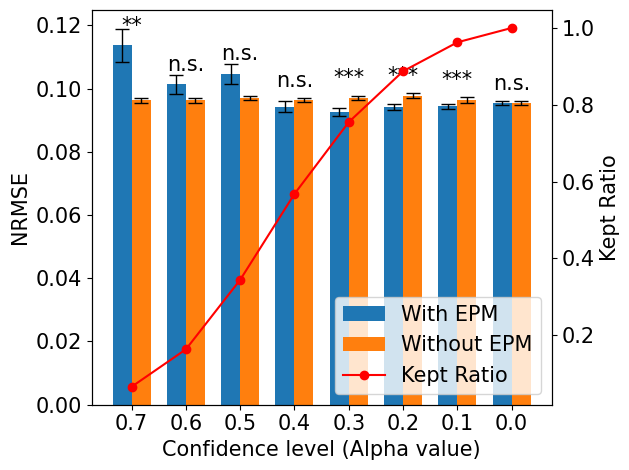

In [12]:
# Calculate the SEM for the coefficients
sem_spearman = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in spearman_coefs]
sem_raw = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in raw_coefs]

fig, ax = plt.subplots()
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars
rects1 = ax.bar(x - width/2, [np.mean(coefs) for coefs in spearman_coefs], width, yerr=sem_spearman, 
                label='With EPM', capsize=5)
rects2 = ax.bar(x + width/2, [np.mean(coefs) for coefs in raw_coefs], width, yerr=sem_raw, 
                label='Without EPM', capsize=5)

def get_significance_asterisks(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'  # not significant

# Calculate p-values and store asterisks
p_values = []
for i in range(7):  # Calculate for the first 7 bars
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    p_values.append(get_significance_asterisks(p))
p_values.append(get_significance_asterisks(1))  # Add the last p-value of 1

# Adjust error bar width
for bar in [rects1, rects2]:
    for err_line in bar.errorbar.lines[2]:
        err_line.set_linewidth(1)

# Plot line
ax2.plot(x, [np.mean(ratios) for ratios in kept_ratios], color='red', marker='o', label='Kept Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NRMSE', fontsize=15)
ax2.set_ylabel('Kept Ratio', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Confidence level (Alpha value)', fontsize=15)

# Add asterisk notation above the middle of each group of bars
for idx, (r1, r2) in enumerate(zip(rects1, rects2)):
    middle_x = r1.get_x() + (r2.get_x() + r2.get_width() - r1.get_x()) / 2
    max_height = max(r1.get_height(), r2.get_height())
    ax.text(middle_x, max_height + 0.003, p_values[idx], ha='center', va='bottom', fontsize=15)

# Set fontsize of tick labels on both x and y axes to 15
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)  # Assuming ax2 is for the secondary y-axis

# Adjust location of the legend to avoid overlap
fig.legend(loc="upper right", bbox_to_anchor=(1,0.3), bbox_transform=ax.transAxes, fontsize=15)

fig.tight_layout()




plt.savefig('errormodel_nrmse.pdf', format='pdf') 

In [13]:
# Wilcoxon test
for i in range(7):
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    print('Alpha percentile:', labels[i])
    print('Wilcoxon test: W = %0.5f, p-value = %0.5f' % (w, p))


Alpha percentile: 0.7
Wilcoxon test: W = 535.00000, p-value = 0.00515
Alpha percentile: 0.6
Wilcoxon test: W = 797.00000, p-value = 0.38503
Alpha percentile: 0.5
Wilcoxon test: W = 673.00000, p-value = 0.07483
Alpha percentile: 0.4
Wilcoxon test: W = 666.00000, p-value = 0.06680
Alpha percentile: 0.3
Wilcoxon test: W = 274.00000, p-value = 0.00000
Alpha percentile: 0.2
Wilcoxon test: W = 88.00000, p-value = 0.00000
Alpha percentile: 0.1
Wilcoxon test: W = 81.00000, p-value = 0.00000


# RMSE

In [14]:
from scipy.stats import wilcoxon
from scipy.stats import pearsonr
spearman_coefs = [[] for _ in range(8)]  # 8 alpha percentiles
raw_coefs = [[] for _ in range(8)]
kept_ratios = [[] for _ in range(8)]  # 8 alpha percentiles


def rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse



# Repeat the process 20 times
for i in range(60):
    for j, alpha_percentile in enumerate(range(30, 101, 10)):
        # Divide the test set into a calibration set and a test set
        X_test = df_testset.iloc[:, :1024]  # Do the same for the test set
        y_test = df_testset.iloc[:, -1]
        X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_test, y_test, test_size=0.5)

        # Define and train the first SVM model
        SVM1 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM1.fit(X_train, y_train)

        # Use SVM1 to do prediction in calibrate and test set
        y_calibrate_pred = SVM1.predict(X_calibrate)
        y_test_pred = SVM1.predict(X_test)

        # Define the error
        calibrate_error = abs(y_calibrate - y_calibrate_pred)

        # Set up SVM2 model to predict error value
        SVM2 = SVR(C=10, gamma=0.01, kernel='rbf')
        SVM2.fit(X_calibrate, calibrate_error)

        # Define a alpha value as percentile point of true error values in calibrate set
        alpha = np.percentile(calibrate_error, q=alpha_percentile)

        # Use SVM1 and SVM2 to do prediction in test set
        test_error_pred = SVM2.predict(X_test)

        # Only keep the samples whose predicted error value less than alpha
        indices_to_keep = test_error_pred < alpha
        X_test_kept = X_test[indices_to_keep]
        y_test_kept = y_test[indices_to_keep]

        # Calculate kept ratio
        kept_ratio = len(y_test_kept) / len(y_test)
        kept_ratios[j].append(kept_ratio)

        # Skip if no samples are left
        if len(y_test_kept) == 0:
            print(f'Iteration {i+1}, alpha percentile {alpha_percentile}: No samples left after applying error threshold. Skipping...')
            continue

        # Calculate spearman coefficient for the kept samples
        coef= rmse(y_test_kept, SVM1.predict(X_test_kept))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'RMSE: ', coef)
        spearman_coefs[j].append(coef)

        # Calculate raw spearman coefficient for all samples
        raw_coef= rmse(y_test, SVM1.predict(X_test))
        print('Iteration', i+1, 'Alpha percentile', alpha_percentile, 'RMSE: ', raw_coef)
        raw_coefs[j].append(raw_coef)


Iteration 1 Alpha percentile 30 RMSE:  0.25839473576575217
Iteration 1 Alpha percentile 30 RMSE:  0.7412662851676616
Iteration 1 Alpha percentile 40 RMSE:  0.5260491340499244
Iteration 1 Alpha percentile 40 RMSE:  0.7582329591424487
Iteration 1 Alpha percentile 50 RMSE:  0.7378981301029705
Iteration 1 Alpha percentile 50 RMSE:  0.7224842280538072
Iteration 1 Alpha percentile 60 RMSE:  0.7661751714885117
Iteration 1 Alpha percentile 60 RMSE:  0.7699614618483932
Iteration 1 Alpha percentile 70 RMSE:  0.6704440663979673
Iteration 1 Alpha percentile 70 RMSE:  0.684215378675173
Iteration 1 Alpha percentile 80 RMSE:  0.6950125862296777
Iteration 1 Alpha percentile 80 RMSE:  0.7618036139771376
Iteration 1 Alpha percentile 90 RMSE:  0.6124415044243542
Iteration 1 Alpha percentile 90 RMSE:  0.6229596837768765
Iteration 1 Alpha percentile 100 RMSE:  0.7333527100604381
Iteration 1 Alpha percentile 100 RMSE:  0.7333527100604381
Iteration 2 Alpha percentile 30 RMSE:  0.3545947873646564
Iteration 2 

Iteration 9 Alpha percentile 100 RMSE:  0.7490054697226817
Iteration 9 Alpha percentile 100 RMSE:  0.7490054697226817
Iteration 10 Alpha percentile 30 RMSE:  0.5135338471650461
Iteration 10 Alpha percentile 30 RMSE:  0.6747221624249558
Iteration 10 Alpha percentile 40 RMSE:  0.4392973332539375
Iteration 10 Alpha percentile 40 RMSE:  0.7470974722509925
Iteration 10 Alpha percentile 50 RMSE:  0.511452449213164
Iteration 10 Alpha percentile 50 RMSE:  0.80136462214569
Iteration 10 Alpha percentile 60 RMSE:  0.6401569463860964
Iteration 10 Alpha percentile 60 RMSE:  0.6744917954085813
Iteration 10 Alpha percentile 70 RMSE:  0.6988267477995433
Iteration 10 Alpha percentile 70 RMSE:  0.7164098864894339
Iteration 10 Alpha percentile 80 RMSE:  0.6658373249571851
Iteration 10 Alpha percentile 80 RMSE:  0.7050008300242564
Iteration 10 Alpha percentile 90 RMSE:  0.7816914673014935
Iteration 10 Alpha percentile 90 RMSE:  0.8144803367700936
Iteration 10 Alpha percentile 100 RMSE:  0.707938001315468


Iteration 18 Alpha percentile 80 RMSE:  0.709675006224036
Iteration 18 Alpha percentile 80 RMSE:  0.7333619046499521
Iteration 18 Alpha percentile 90 RMSE:  0.7571766029859125
Iteration 18 Alpha percentile 90 RMSE:  0.7483088592818634
Iteration 18 Alpha percentile 100 RMSE:  0.699021988139128
Iteration 18 Alpha percentile 100 RMSE:  0.699021988139128
Iteration 19 Alpha percentile 30 RMSE:  0.4433773460899436
Iteration 19 Alpha percentile 30 RMSE:  0.7392372666242099
Iteration 19 Alpha percentile 40 RMSE:  0.43987064900605793
Iteration 19 Alpha percentile 40 RMSE:  0.6335306728042023
Iteration 19 Alpha percentile 50 RMSE:  0.6612072738400012
Iteration 19 Alpha percentile 50 RMSE:  0.8097338075551982
Iteration 19 Alpha percentile 60 RMSE:  0.7065003381367075
Iteration 19 Alpha percentile 60 RMSE:  0.7442823725436271
Iteration 19 Alpha percentile 70 RMSE:  0.7152076619315708
Iteration 19 Alpha percentile 70 RMSE:  0.7596061176947416
Iteration 19 Alpha percentile 80 RMSE:  0.75886806661555

Iteration 27 Alpha percentile 60 RMSE:  0.7471517797251975
Iteration 27 Alpha percentile 60 RMSE:  0.757690574788357
Iteration 27 Alpha percentile 70 RMSE:  0.6187596476316911
Iteration 27 Alpha percentile 70 RMSE:  0.6719842889170062
Iteration 27 Alpha percentile 80 RMSE:  0.6930080266731519
Iteration 27 Alpha percentile 80 RMSE:  0.7205559521679995
Iteration 27 Alpha percentile 90 RMSE:  0.7125239511777164
Iteration 27 Alpha percentile 90 RMSE:  0.7128250264844137
Iteration 27 Alpha percentile 100 RMSE:  0.6722657448696883
Iteration 27 Alpha percentile 100 RMSE:  0.6722657448696883
Iteration 28 Alpha percentile 30 RMSE:  0.467478236189787
Iteration 28 Alpha percentile 30 RMSE:  0.7840316505082635
Iteration 28 Alpha percentile 40 RMSE:  0.5332779728070939
Iteration 28 Alpha percentile 40 RMSE:  0.7715601890252585
Iteration 28 Alpha percentile 50 RMSE:  0.7176881184891836
Iteration 28 Alpha percentile 50 RMSE:  0.7323418222774917
Iteration 28 Alpha percentile 60 RMSE:  0.61612383424268

Iteration 36 Alpha percentile 40 RMSE:  0.5119423590618409
Iteration 36 Alpha percentile 40 RMSE:  0.7126204464477486
Iteration 36 Alpha percentile 50 RMSE:  0.685631924949551
Iteration 36 Alpha percentile 50 RMSE:  0.6732162508352727
Iteration 36 Alpha percentile 60 RMSE:  0.6411927399962744
Iteration 36 Alpha percentile 60 RMSE:  0.6845242018543994
Iteration 36 Alpha percentile 70 RMSE:  0.6647962002128167
Iteration 36 Alpha percentile 70 RMSE:  0.7218491875860066
Iteration 36 Alpha percentile 80 RMSE:  0.6448918436321294
Iteration 36 Alpha percentile 80 RMSE:  0.6683415162975723
Iteration 36 Alpha percentile 90 RMSE:  0.6242410140332757
Iteration 36 Alpha percentile 90 RMSE:  0.6249098116707361
Iteration 36 Alpha percentile 100 RMSE:  0.7537815614354423
Iteration 36 Alpha percentile 100 RMSE:  0.7537815614354423
Iteration 37 Alpha percentile 30 RMSE:  0.380716103837695
Iteration 37 Alpha percentile 30 RMSE:  0.7006478733045793
Iteration 37 Alpha percentile 40 RMSE:  0.45227746580006

Iteration 44 Alpha percentile 100 RMSE:  0.6817356420492672
Iteration 44 Alpha percentile 100 RMSE:  0.6817356420492672
Iteration 45 Alpha percentile 30 RMSE:  0.8690472015480356
Iteration 45 Alpha percentile 30 RMSE:  0.6795083418560383
Iteration 45 Alpha percentile 40 RMSE:  0.520687509891151
Iteration 45 Alpha percentile 40 RMSE:  0.7259797170079118
Iteration 45 Alpha percentile 50 RMSE:  0.6649771440847275
Iteration 45 Alpha percentile 50 RMSE:  0.7830451957231686
Iteration 45 Alpha percentile 60 RMSE:  0.5749858642416016
Iteration 45 Alpha percentile 60 RMSE:  0.6823910479651177
Iteration 45 Alpha percentile 70 RMSE:  0.6827980934030324
Iteration 45 Alpha percentile 70 RMSE:  0.7234107787341458
Iteration 45 Alpha percentile 80 RMSE:  0.6374690422876769
Iteration 45 Alpha percentile 80 RMSE:  0.6765228995035011
Iteration 45 Alpha percentile 90 RMSE:  0.729105870860243
Iteration 45 Alpha percentile 90 RMSE:  0.7495662999239397
Iteration 45 Alpha percentile 100 RMSE:  0.7606221500364

Iteration 53 Alpha percentile 80 RMSE:  0.6900864492041456
Iteration 53 Alpha percentile 80 RMSE:  0.6982317990992729
Iteration 53 Alpha percentile 90 RMSE:  0.6993953574957326
Iteration 53 Alpha percentile 90 RMSE:  0.7026654655984025
Iteration 53 Alpha percentile 100 RMSE:  0.7370590264676052
Iteration 53 Alpha percentile 100 RMSE:  0.7370590264676052
Iteration 54 Alpha percentile 30 RMSE:  0.6689083302708397
Iteration 54 Alpha percentile 30 RMSE:  0.7332133876015654
Iteration 54 Alpha percentile 40 RMSE:  0.6651693797588049
Iteration 54 Alpha percentile 40 RMSE:  0.7802892088174463
Iteration 54 Alpha percentile 50 RMSE:  0.6190976251392606
Iteration 54 Alpha percentile 50 RMSE:  0.6842112495711341
Iteration 54 Alpha percentile 60 RMSE:  0.5489554919822595
Iteration 54 Alpha percentile 60 RMSE:  0.7189836207692687
Iteration 54 Alpha percentile 70 RMSE:  0.6046795700030643
Iteration 54 Alpha percentile 70 RMSE:  0.7332176032397436
Iteration 54 Alpha percentile 80 RMSE:  0.747119579461

In [15]:
# Create a bar plot
labels = [ '0.7','0.6','0.5','0.4', '0.3', '0.2', '0.1', '0.0']  # Alpha percentiles
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

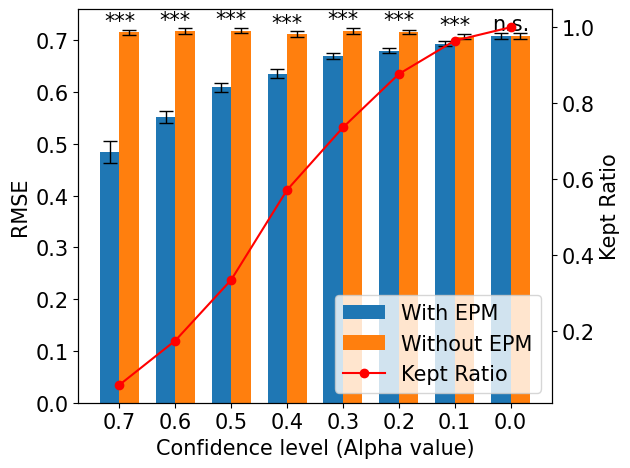

In [16]:
# Calculate the SEM for the coefficients
sem_spearman = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in spearman_coefs]
sem_raw = [np.std(coefs) / np.sqrt(len(coefs)) for coefs in raw_coefs]

fig, ax = plt.subplots()
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# Plot bars
rects1 = ax.bar(x - width/2, [np.mean(coefs) for coefs in spearman_coefs], width, yerr=sem_spearman, 
                label='With EPM', capsize=5)
rects2 = ax.bar(x + width/2, [np.mean(coefs) for coefs in raw_coefs], width, yerr=sem_raw, 
                label='Without EPM', capsize=5)

def get_significance_asterisks(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'n.s.'  # not significant

# Calculate p-values and store asterisks
p_values = []
for i in range(7):  # Calculate for the first 7 bars
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    p_values.append(get_significance_asterisks(p))
p_values.append(get_significance_asterisks(1))  # Add the last p-value of 1

# Adjust error bar width
for bar in [rects1, rects2]:
    for err_line in bar.errorbar.lines[2]:
        err_line.set_linewidth(1)

# Plot line
ax2.plot(x, [np.mean(ratios) for ratios in kept_ratios], color='red', marker='o', label='Kept Ratio')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE', fontsize=15)
ax2.set_ylabel('Kept Ratio', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel('Confidence level (Alpha value)', fontsize=15)

# Add asterisk notation above the middle of each group of bars
for idx, (r1, r2) in enumerate(zip(rects1, rects2)):
    middle_x = r1.get_x() + (r2.get_x() + r2.get_width() - r1.get_x()) / 2
    max_height = max(r1.get_height(), r2.get_height())
    ax.text(middle_x, max_height + 0.003, p_values[idx], ha='center', va='bottom', fontsize=15)

# Set fontsize of tick labels on both x and y axes to 15
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)  # Assuming ax2 is for the secondary y-axis

# Adjust location of the legend to avoid overlap
fig.legend(loc="upper right", bbox_to_anchor=(1,0.3), bbox_transform=ax.transAxes, fontsize=15)

fig.tight_layout()





plt.savefig('errormodel_rmse.pdf', format='pdf') 

In [17]:
# Wilcoxon test
for i in range(7):
    w, p = wilcoxon(spearman_coefs[i], raw_coefs[i])
    print('Alpha percentile:', labels[i])
    print('Wilcoxon test: W = %0.5f, p-value = %0.5f' % (w, p))


Alpha percentile: 0.7
Wilcoxon test: W = 47.00000, p-value = 0.00000
Alpha percentile: 0.6
Wilcoxon test: W = 21.00000, p-value = 0.00000
Alpha percentile: 0.5
Wilcoxon test: W = 12.00000, p-value = 0.00000
Alpha percentile: 0.4
Wilcoxon test: W = 21.00000, p-value = 0.00000
Alpha percentile: 0.3
Wilcoxon test: W = 1.00000, p-value = 0.00000
Alpha percentile: 0.2
Wilcoxon test: W = 9.00000, p-value = 0.00000
Alpha percentile: 0.1
Wilcoxon test: W = 121.00000, p-value = 0.00000
